In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from math import comb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR
from scipy.interpolate import splprep, splev

## Dataset

**Dataset Preparation Overview**

This notebook focuses on preparing a dataset of fluid flow images by:

- Loading and binarizing input images

- Performing interpolation between images to generate intermediate frames

- Processing and saving the resulting dataset

- Analyzing image dimensions across the dataset

**Key steps include:**

- Contour-based interpolation between pairs of images

- Weighted blending of image features

- Padding images to consistent dimensions

- Generating meaningful filenames for blended images

In [2]:
def load_and_binarize(image_path):
    """Loads an image from given path and converts it to binary format using thresholding.
    Args:
        image_path (str): Path to the input image file
    Returns:
        numpy.ndarray: Binarized image array
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return np.array(binary)

In [43]:
def find_min_max(col):
    """Finds the minimum and maximum y-indices where pixel values are 0 (black) in a column.
    Args:
        col (numpy.ndarray): Single column of image data
    Returns:
        tuple: (y_min, y_max) coordinates of first and last black pixels
    """
    zero_indices = np.argwhere(col == 0)
    
    y_min = int(np.min(zero_indices))
    y_max = int(np.max(zero_indices))
    
    return y_min, y_max

In [4]:
def both_have_points(col1,col2):
    """Checks if both columns contain at least one black pixel (value 0).
    Args:
        col1 (numpy.ndarray): First image column
        col2 (numpy.ndarray): Second image column
    Returns:
        bool: True if both columns contain black pixels
    """
    col1_have = len(np.argwhere(col1 == 0)) > 0
    col2_have = len(np.argwhere(col2 == 0)) > 0
    return col1_have & col2_have

In [5]:
def calculate_weighted(col1, col2, weight=0.5):
    """Calculates weighted average of min/max positions between two columns.
    Args:
        col1 (numpy.ndarray): First image column
        col2 (numpy.ndarray): Second image column
        weight (float): Blend weight between 0-1
    Returns:
        tuple: (y_w_min, y_w_max) weighted positions
    """
    y1_min, y1_max = find_min_max(col1)
    y2_min, y2_max = find_min_max(col2)
    y_w_min = int((1-weight)*y1_min + weight*y2_min)
    y_w_max = int((1-weight)*y1_max + weight*y2_max)
    
    return y_w_min, y_w_max

Interpolation function

In [361]:
def interpolation(img1,img2,n_step=1):
    """Generates interpolated images between two input images using contour blending.
    Args:
        img1 (numpy.ndarray): First input image
        img2 (numpy.ndarray): Second input image
        n_step (int): Number of interpolation steps
    Returns:
        list: List of interpolated images
        list: List of corresponding weights
    """
    
    H1, W1 = img1.shape
    H2, W2 = img2.shape
    H = max(H1,H2)
    W = min(W1,W2)

    weight_step = 1 / (n_step+1)
    weights = [weight_step*i for i in range(n_step+1)]
    weights = weights[1:]

    img_list = []
    for weight in weights:
        
        img_w = 255*np.ones((H,W))
        for i in range(W):
            if both_have_points(img1[:,i],img2[:,i]):
            
                y_w_min, y_w_max = calculate_weighted(img1[:,i],img2[:,i],weight=weight)
                img_w[y_w_min:y_w_max+1,i] = 0

        # img_w = img_w.astype(np.uint8)
        # inverted = cv2.bitwise_not(img_w)
        # contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # contour_image = 255*np.ones((H,W))
        # cv2.drawContours(contour_image, contours, -1, 0, thickness=1)
        # img_list.append(contour_image)

        img_w = img_w.astype(np.uint8)
        inverted = cv2.bitwise_not(img_w)
        img_list.append(inverted)

    return img_list, weights

In [7]:
def pad_image_to_max_size(img, H_max=460, W_max=650):
    """Pads an image to specified maximum dimensions with white background (255 values).
    
    Centers the original image in the padded area. Useful for standardizing image sizes 
    in a dataset while preserving aspect ratio.
    
    Args:
        img (numpy.ndarray): Input grayscale image as 2D array
        H_max (int, optional): Maximum height for output image. Defaults to 460.
        W_max (int, optional): Maximum width for output image. Defaults to 650.
    
    Returns:
        numpy.ndarray: Padded image with dimensions (H_max, W_max)
    """
    padded_img = np.full((H_max, W_max), 255, dtype=np.uint8)

    H, W = img.shape
    y_start = (H_max - H) // 2
    x_start = (W_max - W) // 2

    padded_img[y_start:y_start+H, x_start:x_start+W] = img

    return padded_img

In [8]:
def load_images_to_dict(folder_path):
    """Loads all PNG images from a directory into a dictionary with standardized dimensions.
    
    Processes images by:
    1. Finding maximum height/width across all images
    2. Loading each image
    3. Binarizing using load_and_binarize()
    4. Padding to max dimensions using pad_image_to_max_size()
    5. Storing in dictionary with filenames as keys
    
    Args:
        folder_path (str): Path to directory containing PNG images
        
    Returns:
        dict: Dictionary where:
              - Key: filename (str)
              - Value: processed image array (numpy.ndarray)
              
    Raises:
        ValueError: If specified folder_path doesn't exist
    """
    images_dict = {}

    H_max = max(Image.open(os.path.join(folder_path, f)).size[1] for f in os.listdir(folder_path) if f.endswith(".png"))
    W_max = max(Image.open(os.path.join(folder_path, f)).size[0] for f in os.listdir(folder_path) if f.endswith(".png"))
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist")
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        if os.path.isfile(file_path):
            try:
                processed_image = load_and_binarize(file_path)
                resized_image = pad_image_to_max_size(processed_image, H_max, W_max)
                images_dict[filename] = resized_image
            except Exception as e:
                print(f"Failed to process file {filename}: {e}")
    
    return images_dict


In [9]:
def generate_blended_filename(img1_name, img2_name, weight, out_path):
    """Generates a standardized filename for blended images based on source images and blend weight.
    
    Extracts numerical indices from input filenames and creates a new filename in the format:
    'idx_[img1_num]_[img2_num]_[weight_percent].png' in the specified output directory.

    Args:
        img1_name (str): Filename of first source image (e.g., 'frame1.png')
        img2_name (str): Filename of second source image (e.g., 'frame2.png') 
        weight (float): Blend weight between 0 and 1 (e.g., 0.25 for 25% blend)
        out_path (str): Directory path to save the new file
        
    Returns:
        str: Full output path for blended image (e.g., '/output/idx_1_2_25.png')
    """
    idx1 = int(''.join(filter(str.isdigit, img1_name)))
    idx2 = int(''.join(filter(str.isdigit, img2_name)))
    weight_str = f"{round(weight * 100)}"
    filename = f"idx_{idx1}_{idx2}_{weight_str}.png"

    return os.path.join(out_path, filename)

Main function for generating dataset

In [10]:
def prepare_and_save_dataset(ref_img_path, out_path='dataset', n_step=1):
    """Generates and saves a dataset of interpolated fluid flow images between all image pairs.
    
    Creates a complete dataset by:
    1. Loading all reference images from input directory
    2. Generating interpolated images between every unique pair
    3. Saving results with standardized naming convention
    4. Including self-interpolation for each reference image

    Args:
        ref_img_path (str): Path to directory containing reference PNG images
        out_path (str, optional): Output directory for generated dataset. Defaults to 'dataset'.
        n_step (int, optional): Number of interpolation steps between each image pair. Defaults to 1.

    Returns:
        None: Outputs files to disk instead of returning values

    Prints:
        Progress information including:
        - Number of reference images
        - Number of unique pairs
        - Dataset size calculations
        - Current interpolation pairs being processe
    """
    
    input_img_dict = load_images_to_dict(ref_img_path)
    keys = list(input_img_dict.keys())
    n = len(keys)

    print(f'Number of reference images: {n}\nNumber of unique pairs: {comb(n,2)}\nNumner of interpolation steps: {n_step}')
    print(f'Size of dataset: {n_step*comb(n,2)} interpolated images + {n} reference images = {n_step*comb(n,2)+n} images')

    os.makedirs(out_path, exist_ok=True)
    for i in range(n):
        for j in range(i+1, n):
            print(f'Interpolation between images: {keys[i]}, {keys[j]}')
            img_list, weights = interpolation(input_img_dict[keys[i]], input_img_dict[keys[j]], n_step=n_step)

            for k, img in enumerate(img_list):
                filename = generate_blended_filename(keys[i], keys[j], weights[k], out_path)
                img = img.astype(np.uint8)
                Image.fromarray(img).save(filename)

        img_list, weights = interpolation(input_img_dict[keys[i]], input_img_dict[keys[i]], n_step=1)

        for k, img in enumerate(img_list):
            filename = generate_blended_filename(keys[i], keys[i], weights[k], out_path)
            img = img.astype(np.uint8)
            Image.fromarray(img).save(filename)

    print('Done!')

    return None

Generate Dataset

In [362]:
prepare_and_save_dataset('reference_images',out_path='dataset',n_step=9)

Number of reference images: 12
Number of unique pairs: 66
Numner of interpolation steps: 9
Size of dataset: 594 interpolated images + 12 reference images = 606 images
Interpolation between images: img1.png, img10.png
Interpolation between images: img1.png, img11.png
Interpolation between images: img1.png, img12.png
Interpolation between images: img1.png, img2.png
Interpolation between images: img1.png, img3.png
Interpolation between images: img1.png, img4.png
Interpolation between images: img1.png, img5.png
Interpolation between images: img1.png, img6.png
Interpolation between images: img1.png, img7.png
Interpolation between images: img1.png, img8.png
Interpolation between images: img1.png, img9.png
Interpolation between images: img10.png, img11.png
Interpolation between images: img10.png, img12.png
Interpolation between images: img10.png, img2.png
Interpolation between images: img10.png, img3.png
Interpolation between images: img10.png, img4.png
Interpolation between images: img10.png

In [12]:
H_max = max(Image.open(os.path.join('dataset', f)).size[1] for f in os.listdir('dataset') if f.endswith(".png"))
H_min = min(Image.open(os.path.join('dataset', f)).size[1] for f in os.listdir('dataset') if f.endswith(".png"))
W_max = max(Image.open(os.path.join('dataset', f)).size[0] for f in os.listdir('dataset') if f.endswith(".png"))
W_min = min(Image.open(os.path.join('dataset', f)).size[0] for f in os.listdir('dataset') if f.endswith(".png"))

print(f'H_max = {H_max}, W_max = {W_max}')
print(f'H_min = {H_min}, W_max = {W_min}')

H_max = 460, W_max = 648
H_min = 460, W_max = 648


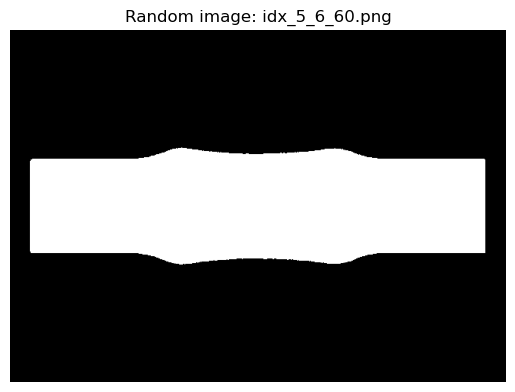

In [8]:
image_folder = 'dataset'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

random_image = random.choice(image_files)
image_path = os.path.join(image_folder, random_image)

img = cv2.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Random image: {random_image}')
plt.show()